## Configuration

In [0]:
username = "sparsha"
experiment_id = None

In [0]:
projectPath     = f"/dbacademy/{username}/mlmodels/profile/"
landingPath     = projectPath + "landing/"
silverDailyPath = projectPath + "daily/"
dimUserPath     = projectPath + "users/"
goldPath        = projectPath + "gold/"

In [0]:
spark.sql(f"CREATE DATABASE IF NOT EXISTS dbacademy_{username}")
spark.sql(f"USE dbacademy_{username}");

In [0]:
from pyspark.sql import SparkSession
from urllib.request import urlretrieve

def retrieve_data(file: str) -> bool:
  """Download file from remote location to driver. Move from driver to DBFS."""

  base_url = "https://files.training.databricks.com/static/data/health-tracker/"
  url = base_url + file
  driverPath = "file:/databricks/driver/" + file
  dbfsPath   = landingPath + file
  urlretrieve(url, file)
  dbutils.fs.mv(driverPath , dbfsPath)
  return True

def load_delta_table(file: str, delta_table_path: str) -> bool:
  "Load a parquet file as a Delta table."
  parquet_df = spark.read.format("parquet").load(landingPath + file)
  parquet_df.write.format("delta").mode("overwrite").save(delta_table_path)
  return True

def process_file(file_name: str, path: str,  table_name: str) -> bool:
  """
  1. retrieve file
  2. load as delta table
  3. register table in the metastore
  """

  retrieve_data(file_name)
  print(f"Retrieve {file_name}.")

  load_delta_table(file_name, path)
  print(f"Load {file_name} to {path}")

  spark.sql(f"""
  DROP TABLE IF EXISTS {table_name}
  """)

  spark.sql(f"""
  CREATE TABLE {table_name}
  USING DELTA
  LOCATION "{path}"
  """)

  print(f"Register {table_name} using path: {path}")

## Retrieve and Load the Data

We will be working with two files:

- "health_profile_data.snappy.parquet"
- "user_profile_data.snappy.parquet"

These files can be retrieved and loaded using the utility function `process_file`

This function takes three arguments:

- `file_name: str`
   - the name of the file to retrieve
- `path: str`
   - the location to write the file as a Delta table
- `table_name: str`
   - the name of a table to be used in the Metastore to reference the data

This function does three things:

1. Retrieve a file and load it into your Databricks Workspace.
1. Create a Delta table using the file.
1. Register the Delta table in the Metastore so that it can be
   referenced using SQL or a PySpark `table` reference.
   
Retrieve the data using the following arguments:

| `file_name` | `path` | `table_name` |
|:-:|:-:|:-|
| `health_profile_data.snappy.parquet` | `silverDailyPath` | `health_profile_data` |
| `user_profile_data.snappy.parquet`   | `dimUserPath`     | `user_profile_data`   |

In [0]:
process_file(
  "health_profile_data.snappy.parquet",
  silverDailyPath,
  "health_profile_data"
)
process_file(
  "user_profile_data.snappy.parquet",
  dimUserPath,
  "user_profile_data"
)

Retrieve health_profile_data.snappy.parquet.
Load health_profile_data.snappy.parquet to /dbacademy/sparsha/mlmodels/profile/daily/
Register health_profile_data using path: /dbacademy/sparsha/mlmodels/profile/daily/
Retrieve user_profile_data.snappy.parquet.
Load user_profile_data.snappy.parquet to /dbacademy/sparsha/mlmodels/profile/users/
Register user_profile_data using path: /dbacademy/sparsha/mlmodels/profile/users/


In a typical workflow, data will have been made available to you
as tables that can be queried using SQL or PySpark. This function
`process_file` has performed the steps necessary to make the files
available to your workspace so that you can focus on data science.
This mirrors a typical workflow, where the data has been made
available by a data engineer.

## Create Augmented Sample

**Define Spark References to Data**

In the next cell, we use Apache Spark to define a reference to the data
we will be working with.

We need to create references to the following Delta tables:

- `user_profile_data`
- `health_profile_data`

In [0]:
# Use spark.read to create references to the two tables as dataframes

user_profile_df = spark.read.table("user_profile_data")
health_profile_df = spark.read.table("health_profile_data")

**Generate a Sample of Users**

In [0]:
user_profile_sample_df = user_profile_df.sample(0.1)

display(user_profile_sample_df.groupby("lifestyle").count())

lifestyle,count
sedentary,91
weight trainer,98
cardio trainer,87


**Join the User Profile Data to the Health Profile Data**

1. Join the two dataframes, `user_profile_sample_df` and `health_profile_df`
1. Perform the join using the `_id` column.

If successful, You should have 365 times as many rows as are in the user sample.

In [0]:
health_profile_sample_df = (
  user_profile_sample_df
  .join(health_profile_df, "_id")
)

assert 365*user_profile_sample_df.count() == health_profile_sample_df.count()

**Aggregate the Data to Generate Numerical Features**

You should perform the following aggregations:

- mean `BMI` aliased to `mean_BMI`
- mean `active_heartrate` aliased to `mean_active_heartrate`
- mean `resting_heartrate` aliased to `mean_resting_heartrate`
- mean `VO2_max` aliased to `mean_VO2_max`
- mean `workout_minutes` aliased to `mean_workout_minutes`

In [0]:
from pyspark.sql.functions import mean, col

health_tracker_sample_agg_df = (
    health_profile_sample_df.groupBy("_id")
    .agg(
        mean("BMI").alias("mean_BMI"),
        mean("active_heartrate").alias("mean_active_heartrate"),
        mean("resting_heartrate").alias("mean_resting_heartrate"),
        mean("VO2_max").alias("mean_VO2_max"),
        mean("workout_minutes").alias("mean_workout_minutes")
    )
)

**Join the Aggregate Data to User Data to Augment with Categorical Features**
1. Join the two dataframes, `health_tracker_sample_agg_df` and `user_profile_df`
1. Perform the join using the `_id` column.

In [0]:
health_tracker_augmented_df = (
  health_tracker_sample_agg_df
  .join(user_profile_df, "_id")
)

**Select only the following features, in this order:**

- `mean_BMI`
- `mean_active_heartrate`
- `mean_resting_heartrate`
- `mean_VO2_max`
- `mean_workout_minutes`
- `female`
- `country`
- `occupation`
- `lifestyle`

In [0]:
health_tracker_augmented_df = (
  health_tracker_augmented_df
  .select(
    "mean_BMI",
    "mean_active_heartrate",
    "mean_resting_heartrate",
    "mean_VO2_max",
    "mean_workout_minutes",
    "female",
    "country",
    "occupation",
    "lifestyle"
  )
)

**Run this Assertion to Verify The Schema**

In [0]:
from pyspark.sql.types import _parse_datatype_string

augmented_schema = """
  mean_BMI double,
  mean_active_heartrate double,
  mean_resting_heartrate double,
  mean_VO2_max double,
  mean_workout_minutes double,
  female boolean,
  country string,
  occupation string,
  lifestyle string
"""

assert health_tracker_augmented_df.schema == _parse_datatype_string(augmented_schema)

**Write the Augmented Dataframe to a Delta Table**

Use the following path: `goldPath + "health_tracker_augmented"`

In [0]:
(
  health_tracker_augmented_df.write
  .format("delta")
  .mode("overwrite")
  .save(goldPath + "health_tracker_augmented")
)

## Exploring the Augmented Sample Data

**Load the Sample Data as a Pandas DataFrame**

Recall that we wrote the sample data as a Delta table to
the path, `goldPath + "health_tracker_augmented"`.

1. Use `spark.read` to read the Delta table as a Spark DataFrame.
2. Use the `.toPandas()` DataFrame method to load the Spark
   DataFrame as a Pandas DataFrame.

In [0]:
health_tracker_augmented_df = (
  spark.read
  .format("delta")
  .load(goldPath + "health_tracker_augmented")
  .toPandas()
)

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [0]:
lifestyles = health_tracker_augmented_df.lifestyle.unique()
lifestyles

Out[23]: array(['weight trainer', 'cardio trainer', 'sedentary'], dtype=object)

**Create Feature and Target Objects**

In [0]:
features = health_tracker_augmented_df.drop("lifestyle", axis=1)
target = health_tracker_augmented_df[["lifestyle"]].copy()

**Display a `.sample()` of the Features DataFrame**

In [0]:
features.sample(10)

,mean_BMI,mean_active_heartrate,mean_resting_heartrate,mean_VO2_max,mean_workout_minutes,female,country,occupation
242,15.604125,107.020972,53.353211,31.753355,26.126726,True,JPN,Other-service
70,23.169272,107.314381,56.971162,33.419453,26.214643,True,USA,Sales
9,15.404991,113.290595,52.798653,29.607253,27.088058,True,PRY,Armed-Forces
158,17.561480,101.855892,50.895660,36.897852,24.442320,True,USA,Craft-repair
134,28.408191,154.327888,68.155987,28.310346,8.389407,False,GHA,Other-service
177,27.116663,121.807308,64.598107,31.476293,25.693750,True,ITA,Adm-clerical
63,17.651348,106.417538,51.737144,36.427727,26.692210,True,USA,Prof-specialty
88,29.422792,136.137326,64.600347,30.283503,8.449815,True,USA,Craft-repair
17,27.830804,147.058693,74.793985,24.330143,8.080163,True,USA,Armed-Forces
28,20.424387,145.411249,86.561641,18.829251,7.832739,False,MYS,Protective-serv


**Display the `.dtypes` of the Features DataFrame**

In [0]:
features.dtypes

Out[26]: mean_BMI                  float64
mean_active_heartrate     float64
mean_resting_heartrate    float64
mean_VO2_max              float64
mean_workout_minutes      float64
female                       bool
country                    object
occupation                 object
dtype: object

In [0]:
features_numerical = features.select_dtypes(include=[float])
features_categorical = features.select_dtypes(exclude=[float])

**Use `seaborn` to Display a Distribution Plot for Each Feature On the Same Scale**

1. Generate a `histplot` for each feature.
1. Set the `xlim` for each axis of the subplot to `0,250`

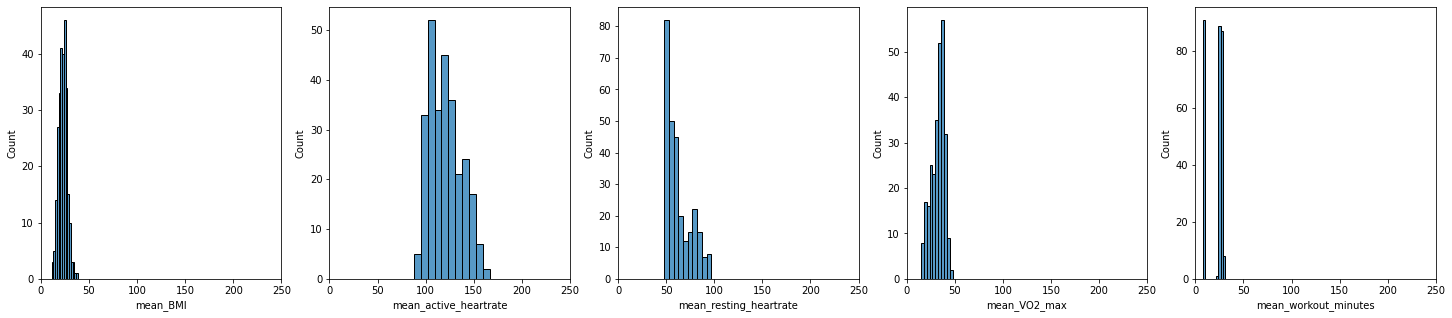

In [0]:
fig, ax = plt.subplots(1,5, figsize=(25,5))

for i, feature in enumerate(features_numerical):
  sns.histplot(features[feature], ax=ax[i])
  ax[i].set_xlim(0,250)

**Use `seaborn` to Display a Scaled Distribution Plot for Each Feature**

1. Create the scaled series by subtracting the mean and dividing by the standard deviation
2. Generate a `histplot` for each feature.
3. Set the `xlim` for each axis of the subplot to `-5, 5`

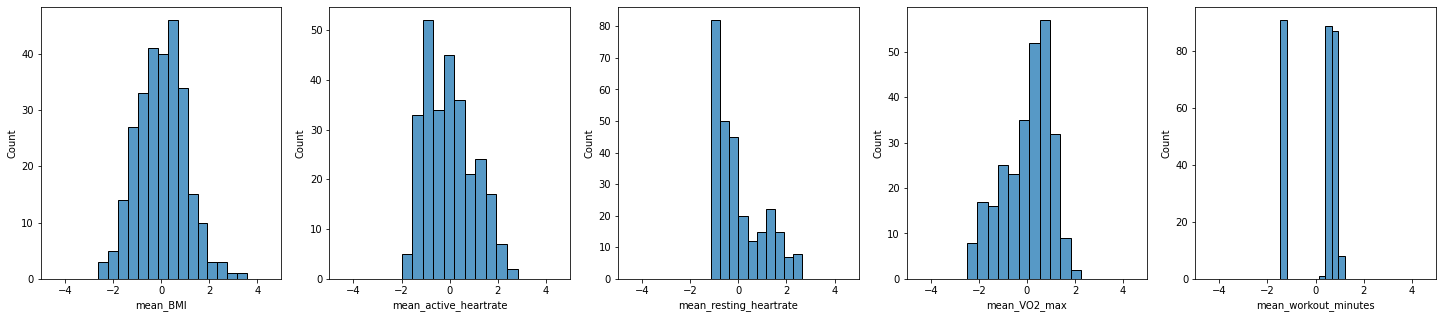

In [0]:
fig, ax = plt.subplots(1,5, figsize=(25,5))

for i, feature in enumerate(features_numerical):
  feature_series = features[feature]
  feature_scaled = (feature_series - feature_series.mean())/feature_series.std()
  sns.histplot(feature_scaled, ax=ax[i])
  ax[i].set_xlim(-5, 5)

**Use `seaborn` to Display a Distribution Plot for Each Feature, Colored by Lifestyle**

1. Filter on the `lifestyle` column from the `target` DataFrame.
1. Set this column equal to the `lifestyle` variable in the for-loop
1. Generate a `histplot` for each feature.

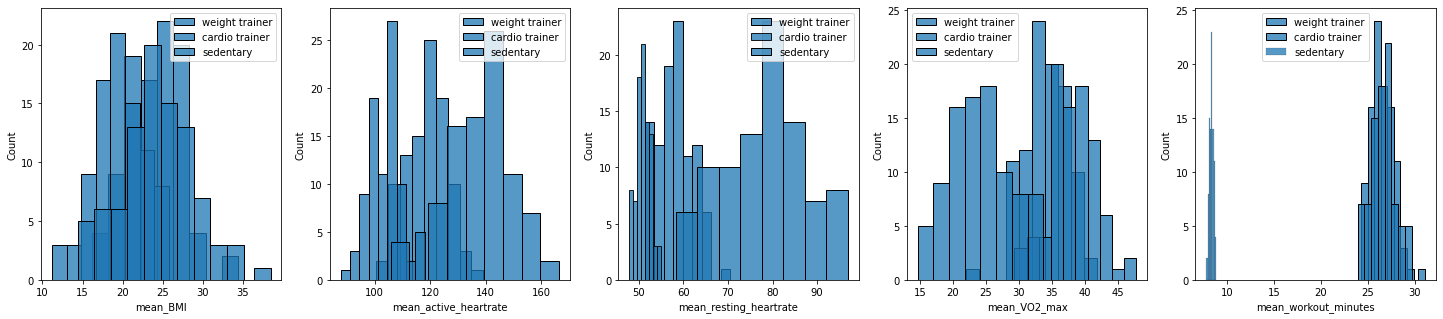

In [0]:
fig, ax = plt.subplots(1,5, figsize=(25,5))

for i, feature in enumerate(features_numerical):
  for lifestyle in lifestyles:
    subset = features[target["lifestyle"] == lifestyle]
    sns.histplot(subset[feature], ax=ax[i], label=lifestyle)
  ax[i].legend()

**Use `seaborn` to Display a Distribution Plot for Resting Heart Rate, Colored by Categorical Feature**

1. exclude the numerical columns when selecting `dtypes`
2. use the seaborn `histplot`

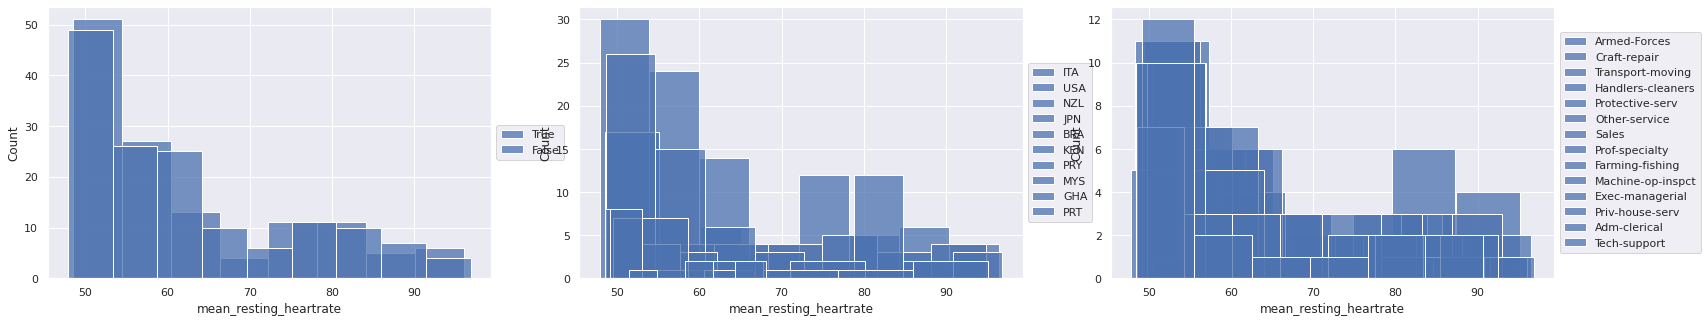

In [0]:
fig, ax = plt.subplots(1,3, figsize=(27,5))

for i, feature in enumerate(features_categorical):
  for value in features[feature].unique():
    subset = features[features[feature] == value]
    sns.histplot(subset["mean_resting_heartrate"], ax=ax[i], label=value)
  ax[i].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

**Use Pandas Plotting to Display a Bar Plot for Each Categorical Feature by Lifestyle**

1. Use 1 row of 3 subplots
1. Group the the three subplots by the columns `female`, `country`, and `occupation`.
1. Use plot kind, `bar` and each subplot to axes, `0`, `1`, and `2`

Out[60]: <matplotlib.legend.Legend at 0x7fc701820970>

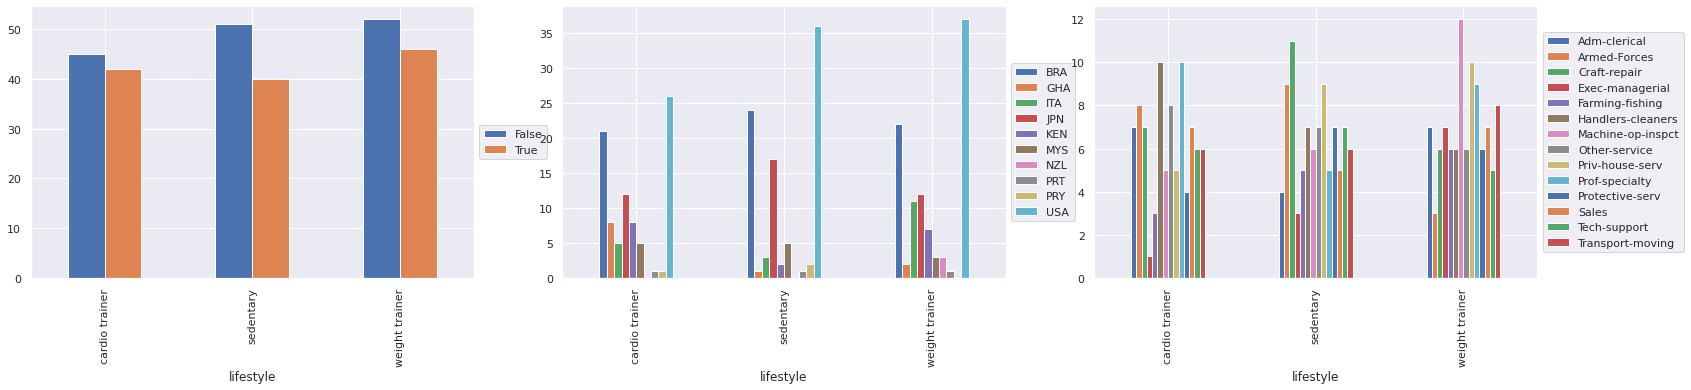

In [0]:
fig, ax = plt.subplots(1, 3, figsize=(27,5))
(
  health_tracker_augmented_df
  .groupby("female")
  .lifestyle.value_counts()
  .unstack(0)
  .plot(kind="bar", ax=ax[0]).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
)
(
  health_tracker_augmented_df
  .groupby("country")
  .lifestyle.value_counts()
  .unstack(0)
  .plot(kind="bar", ax=ax[1]).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
)
(
  health_tracker_augmented_df
  .groupby("occupation")
  .lifestyle.value_counts()
  .unstack(0)
  .plot(kind="bar", ax=ax[2]).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
)

**One-Hot Encoding**

Just as we have to numerically encode our target using
`sklearn.preprocessing.LabelEncoder`,  in order to use our categorical
features — encoded as strings — we are going to need to apply preprocessing.

Categorical features require special handling. They can not be simply
converted to numbers. Rather, we will need to convert them to one-hot encoded
columns.

In [0]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False, drop=None, handle_unknown='ignore')
ohe.fit_transform(features_categorical)

Out[61]: array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

## Experiment Utils

In [0]:
import os
import pandas as pd
import numpy as np
import mlflow

from sklearn.model_selection import GridSearchCV

In [0]:
def mlflow_run(experiment_id, estimator, param_grid, data):
    (X_train, X_test, y_train, y_test) = data

    with mlflow.start_run(experiment_id=experiment_id) as run:
        gs = GridSearchCV(estimator, param_grid)
        gs.fit(X_train, y_train)

        train_acc = gs.score(X_train, y_train)
        test_acc = gs.score(X_test, y_test)
        mlflow.log_param("model",
                         (str(estimator.__class__)
                          .split('.')[-1].replace("'>","")))

        mlflow.sklearn.log_model(gs.best_estimator_, "model")

        for param, value in gs.best_params_.items():
            mlflow.log_param(param, value)
        mlflow.log_metric("train acc", train_acc)
        mlflow.log_metric("test acc", test_acc)

In [0]:
def prepare_results(experiment_id):
    results = mlflow.search_runs(experiment_id)
    columns = [
      col for col in results.columns
      if any([
        'metric' in col,
        'param' in col,
        'artifact' in col
      ])
    ]
    return results[columns]

In [0]:
def prepare_coefs(experiment_id, lifestyles, feature_columns):

    runs = mlflow.search_runs(experiment_id)
    runs = runs[runs.status == "FINISHED"]
    models = runs.artifact_uri.apply(lambda uri: mlflow.sklearn.load_model(uri + "/model"))

    models = [
      {**model.get_params(),
        "coefs" : model.coef_
      } for model in models.values
    ]
    coefs = pd.DataFrame(models)
    coefs = coefs[["C", "l1_ratio", "penalty", "coefs"]]
    coefs["coefs"] = (
      coefs["coefs"]
      .apply(
        lambda artifact: [
          (lifestyle, coefs)
          for lifestyle, coefs
          in zip(lifestyles, artifact)
        ]
      )
    )
    coefs = coefs.explode("coefs")
    coefs["lifestyle"] = coefs["coefs"].apply(lambda artifact: artifact[0])
    coefs["coefs"] = coefs["coefs"].apply(lambda artifact: artifact[1])
    coefs.set_index(["C", "l1_ratio", "penalty", "lifestyle"], inplace=True)
    coefs = coefs["coefs"].apply(pd.Series)
    coefs.columns = feature_columns
    ax = coefs.T.plot(figsize=(20,7))
    ax.set_xticks(range(len(coefs.columns)));
    ax.set_xticklabels(coefs.columns.tolist(), rotation=45)
    return coefs, ax

## Data Preprocessing

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from pyspark.sql.functions import mean, col

In [0]:
ss = StandardScaler()
ohe = OneHotEncoder(sparse=False, drop=None, handle_unknown='ignore')

In [0]:
# Create Spark Reference to Tables
user_profile_df = spark.read.table("user_profile_data")
health_profile_df = spark.read.table("health_profile_data")

In [0]:
# Sample Users and Join to Health Profile
user_profile_sample_df = user_profile_df.sample(0.1)
health_profile_sample_df = (
  user_profile_sample_df
  .join(health_profile_df, "_id")
)

In [0]:
assert 365*user_profile_sample_df.count() == health_profile_sample_df.count()

In [0]:
# Aggregate Over Daily Profile Data
from pyspark.sql.functions import mean, col

health_tracker_sample_agg_df = (
    health_profile_sample_df.groupBy("_id")
    .agg(
        mean("BMI").alias("mean_BMI"),
        mean("active_heartrate").alias("mean_active_heartrate"),
        mean("resting_heartrate").alias("mean_resting_heartrate"),
        mean("VO2_max").alias("mean_VO2_max"),
        mean("workout_minutes").alias("mean_workout_minutes")
    )
)

In [0]:
health_tracker_augmented_df = (
  health_tracker_sample_agg_df
  .join(user_profile_df, "_id")
)

In [0]:
# Select Salient Columns
health_tracker_augmented_df = (
  health_tracker_augmented_df
  .select(
    "mean_BMI",
    "mean_active_heartrate",
    "mean_resting_heartrate",
    "mean_VO2_max",
    "mean_workout_minutes",
    "female",
    "country",
    "occupation",
    "lifestyle"
  )
)

In [0]:
from pyspark.sql.types import _parse_datatype_string

augmented_schema = """
  mean_BMI double,
  mean_active_heartrate double,
  mean_resting_heartrate double,
  mean_VO2_max double,
  mean_workout_minutes double,
  female boolean,
  country string,
  occupation string,
  lifestyle string
"""

assert health_tracker_augmented_df.schema == _parse_datatype_string(augmented_schema)

In [0]:
# Convert the Augmented Spark DataFrame to a Pandas DataFrame
health_tracker_augmented_pandas_df = health_tracker_augmented_df.toPandas()

In [0]:
# Prepare Feature and Target
from sklearn.preprocessing import LabelEncoder

features = health_tracker_augmented_pandas_df.drop("lifestyle", axis=1)
target = health_tracker_augmented_pandas_df["lifestyle"]
le = LabelEncoder()
target = le.fit_transform(target)

In [0]:
# Perform Train-Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target)

In [0]:
# Split Data into Numerical and Categorical Sets
X_train_numerical = X_train.select_dtypes(exclude=["object"])
X_test_numerical = X_test.select_dtypes(exclude=["object"])
X_train_categorical = X_train.select_dtypes(include=["object"])
X_test_categorical = X_test.select_dtypes(include=["object"])

In [0]:
# Create One-Hot Encoded Categorical DataFrames
X_train_ohe = pd.DataFrame(
  ohe.fit_transform(X_train_categorical),
  columns=ohe.get_feature_names(),
  index=X_train_numerical.index
)
X_test_ohe = pd.DataFrame(
  ohe.transform(X_test_categorical),
  columns=ohe.get_feature_names(),
  index=X_test_numerical.index
)

In [0]:
# Merge Numerical and One-Hot Encoded Categorical
X_train = X_train_numerical.merge(X_train_ohe, left_index=True, right_index=True)
X_test = X_test_numerical.merge(X_test_ohe, left_index=True, right_index=True)

In [0]:
# Standardize Data
X_train = pd.DataFrame(
  ss.fit_transform(X_train),
  index=X_train_ohe.index,
  columns=X_train.columns)
X_test = pd.DataFrame(
  ss.transform(X_test),
  index=X_test_ohe.index,
  columns=X_train.columns)

## Building a Linear Customer Classfication Model

In [0]:
from sklearn.linear_model import LogisticRegression

In [0]:
data = (X_train, X_test, y_train, y_test)

**Grid-Searched Model Fitting**

The following models were fit using a grid-searched, cross validation with
the respective parameter dictionaries:

 - Ridge,
   - `{'alpha' : logspace(-5,5,11)}`
 - Lasso,
   - `{'alpha' : logspace(-5,5,11)}`
 - Elastic Net,
   - `{'alpha' : logspace(-5,5,11), 'l1_ratio' : linspace(0,1,11)}`

In [0]:
estimator = LogisticRegression(max_iter=10000)
param_grid = {
  'C' : np.logspace(-5,5,11),
  "penalty" : ['l2']
}
mlflow_run(experiment_id, estimator, param_grid, data)

In [0]:
estimator = LogisticRegression(max_iter=10000)
param_grid = {
  'C' : np.logspace(-5,5,11),
  "penalty" : ['l1'], "solver" : ['saga']
}
mlflow_run(experiment_id, estimator, param_grid, data)

In [0]:
estimator = LogisticRegression(max_iter=10000)
param_grid = {
  'C' : np.logspace(-5,5,11),
  "penalty" : ['elasticnet'],
  'l1_ratio' : np.linspace(0,1,11),
  "solver" : ['saga']
}
mlflow_run(experiment_id, estimator, param_grid, data)

## Display Experiment Results

In [0]:
prepare_results(experiment_id)

,artifact_uri,metrics.train acc,metrics.test acc,params.C,params.solver,params.l1_ratio,params.model,params.penalty
0,dbfs:/databricks/mlflow-tracking/2676673923515...,0.982301,0.973684,1.0,saga,1.0,LogisticRegression,elasticnet
1,dbfs:/databricks/mlflow-tracking/2676673923515...,0.982301,0.973684,1.0,saga,None,LogisticRegression,l1
2,dbfs:/databricks/mlflow-tracking/2676673923515...,1.000000,0.960526,10.0,None,None,LogisticRegression,l2


Out[82]: (                                         mean_BMI  mean_active_heartrate  \
 C    l1_ratio penalty    lifestyle                                         
 1.0  1.0      elasticnet cardio trainer -0.532310              -2.841558   
                          sedentary       0.000000               0.000000   
                          weight trainer  0.000000               0.000000   
      NaN      l1         cardio trainer -0.532355              -2.841687   
                          sedentary       0.000000               0.000000   
                          weight trainer  0.000000               0.000000   
 10.0 NaN      l2         cardio trainer -0.817320              -3.552804   
                          sedentary       0.108205               1.767004   
                          weight trainer  0.709116               1.785800   
 
                                          mean_resting_heartrate  mean_VO2_max  \
 C    l1_ratio penalty    lifestyle                         

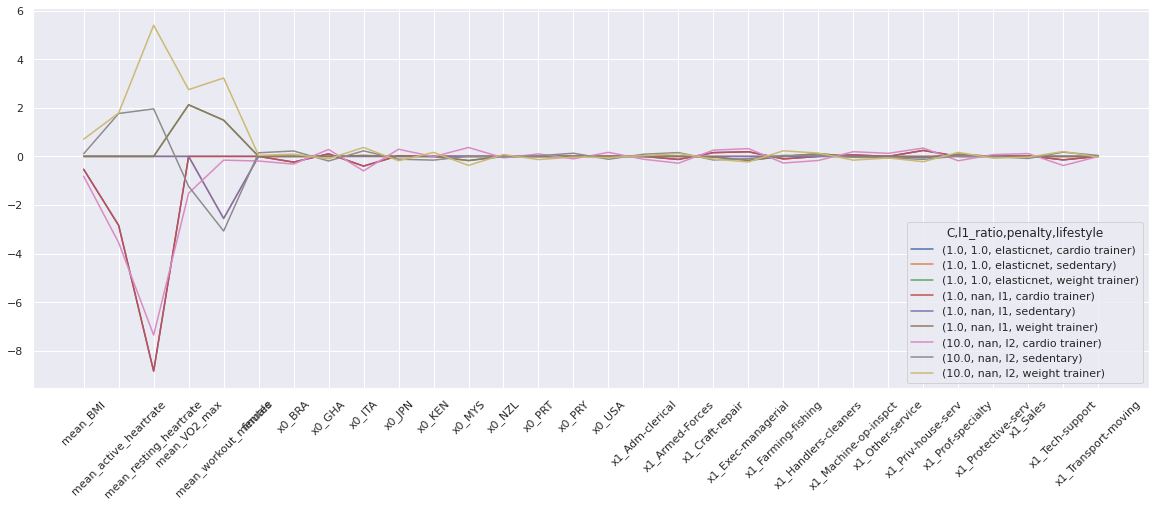

In [0]:
prepare_coefs(experiment_id, le.classes_, X_train.columns)